In [4]:
# ========================== Libraries ===========================
# essentials
import sys, os, time
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# data format related
import csv
from netCDF4 import Dataset as NetCDFFile

# statistics
import scipy.linalg as la
from scipy.interpolate import griddata
from scipy import stats
import scipy.interpolate as scinterp
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss

# ploting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import ticker, cm
from matplotlib.offsetbox import AnchoredText 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy as cart 
import imageio



In [5]:
# ============== Open and read netCDF files ===============
datadir = '/mnt/data-summer/erca-shared-storage/student/GROUP5/MOCCHA'
weather_data_xr = xr.open_dataset(datadir + '/ACAS_AO2018_ship_30min_v1_1.nc')

In [6]:
# Getting rid of NaNs in the time series (to make the resampling )
weather_data_xr = weather_data_xr.dropna(dim="time", subset=["time"])
# Resampling the dataset
weather_data_rsp = weather_data_xr.resample(time = '1h').nearest(tolerance="1D")
weather_data_rsp

<xarray.Dataset> Size: 245kB
Dimensions:     (time: 1392)
Coordinates:
  * time        (time) datetime64[ns] 11kB 2018-08-01 ... 2018-09-27T23:00:00
Data variables: (12/21)
    starttime   (time) float64 11kB ...
    endtime     (time) float64 11kB ...
    doy         (time) timedelta64[ns] 11kB ...
    heading     (time) float64 11kB ...
    cog         (time) float64 11kB ...
    sog         (time) float64 11kB ...
    ...          ...
    templab     (time) float64 11kB ...
    conlab      (time) float64 11kB ...
    sallab      (time) float64 11kB ...
    vellab      (time) float64 11kB ...
    temphull    (time) float64 11kB ...
    salintflag  (time) float64 11kB ...
Attributes: (12/28)
    title:                   ACAS AO2018 Project Meteorology data
    abstract:                Data from the Arctic Climate Across Scales (ACAS...
    Site:                    Arctic Ocean
    Campaign:                Arctic Ocean 2018 (AO2018) August-October 2018
    Platform:                Icebreaker Oden
    topiccategory:           ClimatologyMeteorologyAtmosphere
    ...                      ...
    project_scientist_name:  John Prytherch
    contact:                 john.prytherch@misu.su.se / michaelt@misu.su.se
    distribution_statement:  open
    licence:                 
    project_name:            ACAS / AO2018
    comment:                 The data file provides best estimates of environ...

In [7]:
# Variable selections
sdata = weather_data_rsp[['t','rh', 'wd_tru', 'ws_tru']].to_dataarray()   # and convert from dataset to data array
varnames = ['Temperature','RH','Wind dir.','Wind speed']

Text(0.5, 1.0, 'Normalized data')

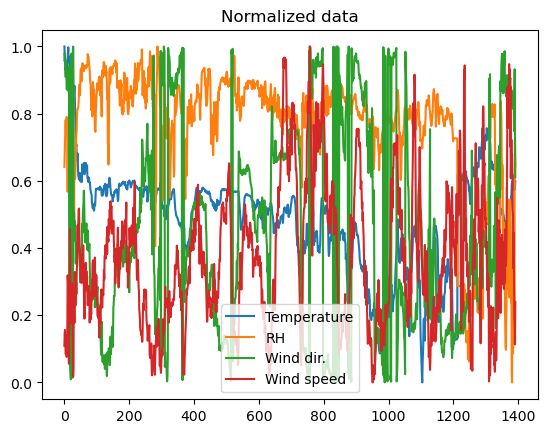

In [8]:
# ======= Normalizing the variables =========
# by standard deviation
data_mean = np.mean(sdata, axis=0)
data_std = np.std(sdata, axis=0)
data_normalized = (sdata - data_mean) / data_std
# by min and max (0-1 range)
data_normalized = []
for i in range(0,sdata.shape[0]):    # loop over the variables
    data_min = np.min(sdata[i])
    data_max = np.max(sdata[i])
    data_normalized.append((sdata[i] - data_min)/(data_max - data_min))
data_norm = np.asarray(data_normalized)   # switch back to numpy array
# plot the normalized dataset
for i in range(0,data_norm.shape[0]):
    plt.plot(data_normalized[i], label = varnames[i])
    plt.legend()
plt.title('Normalized data')


In [9]:
def PCA(data):
    '''
    Standard PCA analysis.
    data : the studied data as numpy array
    '''
    cov_matrix = np.cov(data, rowvar=False)
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sorting them by decreasing order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    total_var = np.sum(eigenvalues)
    vp1 = eigenvalues[0]/eigenvalues.sum().real
    vp2 = eigenvalues[1]/eigenvalues.sum().real
    vp3 = eigenvalues[2]/eigenvalues.sum().real
    pc1 = (eigenvectors[:,0]-eigenvectors[:,0].mean())/eigenvectors[:,0].std()
    pc2 = (eigenvectors[:,1]-eigenvectors[:,1].mean())/eigenvectors[:,1].std()
    pc3 = (eigenvectors[:,2]-eigenvectors[:,2].mean())/eigenvectors[:,2].std()
    # Projecting the data on the eigenvectors space to get the PCs
    pc = np.dot(data, eigenvectors)

    # -------- Figure ---------
    fig = plt.figure(figsize = (8,8))
    fig.suptitle('PCA analysis', fontsize = 16)
    gs = GridSpec(14,14)
    ax = fig.add_subplot(gs[:5,:])
    ax.plot(eigenvalues[0:10].real/eigenvalues.real.sum(), c = 'darkslategrey')
    ax.scatter(np.arange(0,10), eigenvalues[0:10].real/eigenvalues.real.sum(), c = 'teal')
    ax.set_ylabel('Eigen values (normalised)')
    ax.grid()
    ax.set_title('mode 1: {}% ; mode 2: {}% ; mode 3: {}%'.format(round(vp1*100,1), round(vp2*100, 1), round(vp3*100,1)))
    # -------------------------------
    ax2 = fig.add_subplot(gs[6:8,:])
    ax2.plot(pc1, c = 'teal', label = 'PC1')
    ax3 = fig.add_subplot(gs[9:11,:])
    ax3.plot(pc2, c = 'cyan', label = 'PC2')
    ax4 = fig.add_subplot(gs[12:14,:])
    ax4.plot(pc3, c = 'blue', label = 'PC3')
    ax2.set_ylabel('')
    ax4.set_xlabel('Time')
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax2.set_title("Principal components")
    ax2.legend()
    ax3.legend()
    ax4.legend()
    return pc1,pc2,pc3, cov_matrix


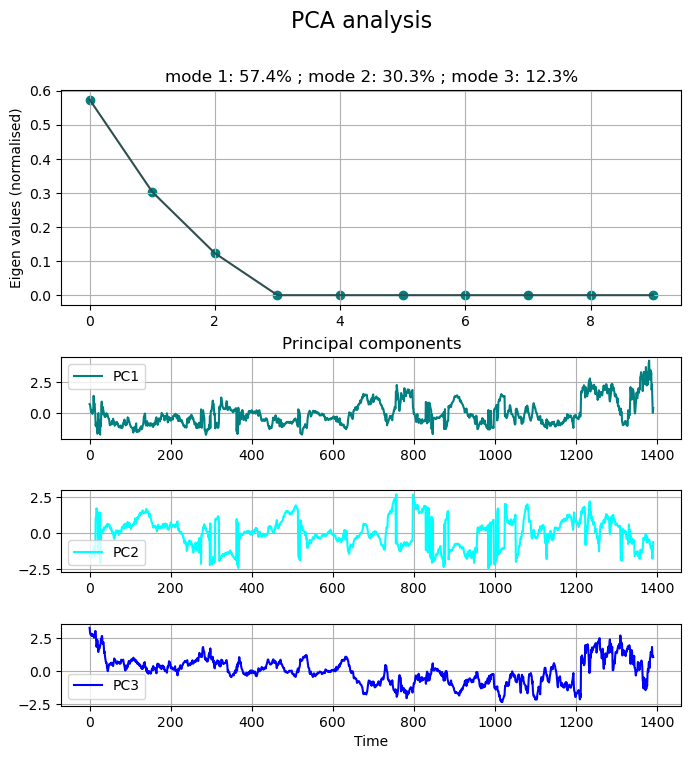

In [10]:
# =========== Execute the analysis ==============
# compute the PCA
pc1, pc2, pc3, cov_matrix = PCA(data_norm)

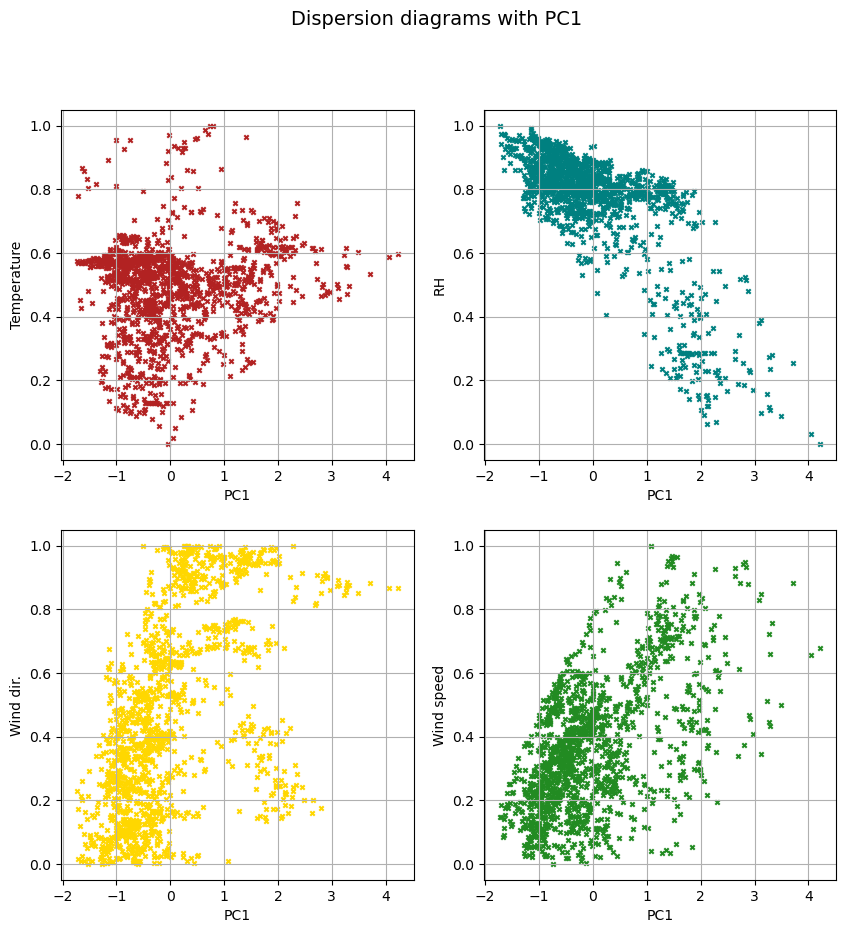

In [17]:
# ========== Correlations Variables vs PC1 ============
colors = ['firebrick','teal','gold','forestgreen']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Dispersion diagrams with PC1', fontsize = 14)
for i in range(0, len(varnames)):
    ax = fig.add_subplot(221 + i)
    ax.grid()
    ax.scatter(pc1, data_norm[i], 10, marker = 'x', color = colors[i])
    ax.set_ylabel('{}'.format(varnames[i]))
    ax.set_xlabel('PC1')
    

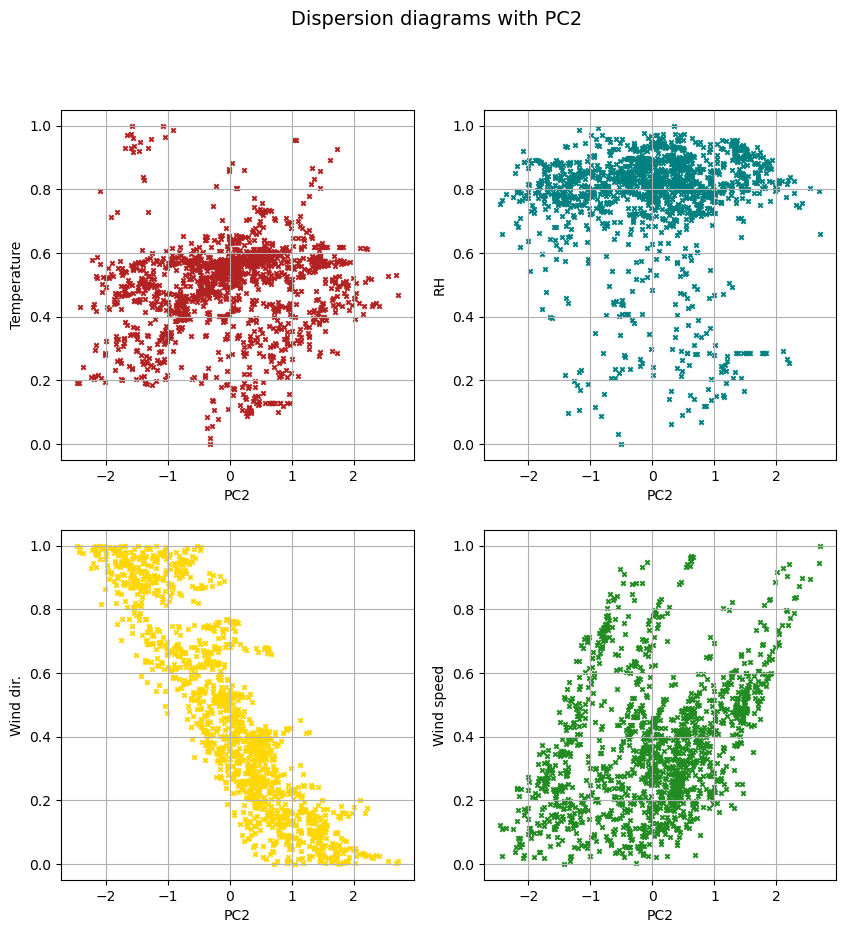

In [16]:
# ========== Correlations Variables vs PC2 ============
colors = ['firebrick','teal','gold','forestgreen']
fig = plt.figure(figsize=(10,10))
fig.suptitle('Dispersion diagrams with PC2', fontsize = 14)
for i in range(0, len(varnames)):
    ax = fig.add_subplot(221 + i)
    ax.grid()
    ax.scatter(pc2, data_norm[i], 10, marker = 'x', color = colors[i])
    ax.set_ylabel('{}'.format(varnames[i]))
    ax.set_xlabel('PC2')

AttributeError: 'Dataset' object has no attribute 'index'

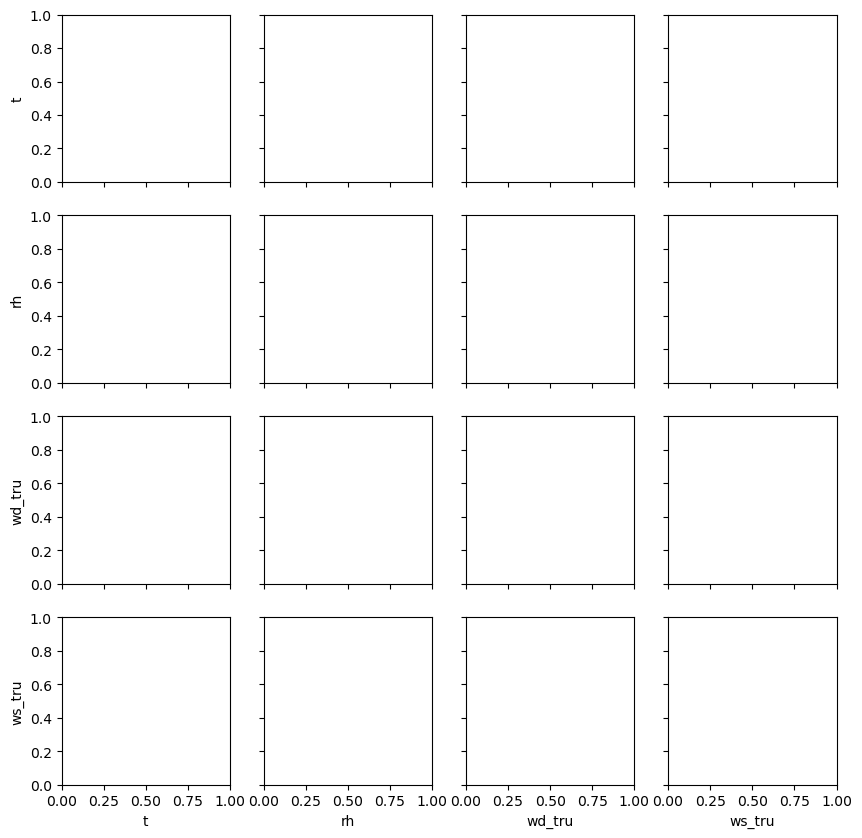

In [68]:
import seaborn as sns

g = sns.PairGrid(sdata_pd)#, hue="variable")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()